## タイタニックの生死予測

In [66]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
                        
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [67]:
#train_data['Cabin'].value_counts()

In [68]:
test_id = test_data['PassengerId']

labels=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
train_data=train_data[labels + ["Survived"]]
test_data=test_data[labels]

train_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22.0,1,0,7.2500,S,0
1,1,female,38.0,1,0,71.2833,C,1
2,3,female,26.0,0,0,7.9250,S,1
3,1,female,35.0,1,0,53.1000,S,1
4,3,male,35.0,0,0,8.0500,S,0


In [69]:
test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [70]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       714 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  889 non-null    object 
 7   Survived  891 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null

In [71]:
age_mean = train_data['Age'].mean()
train_data['Age'] = train_data['Age'].fillna(age_mean)
test_data['Age'] = test_data['Age'].fillna(age_mean)

Fare_mean = train_data['Fare'].mean()
train_data['Fare'] = train_data['Fare'].fillna(Fare_mean)
test_data['Fare'] = test_data['Fare'].fillna(Fare_mean)

Embarked_mode=train_data['Embarked'].mode()
train_data['Embarked'] = train_data['Embarked'].fillna(Embarked_mode)
test_data['Embarked'] = test_data['Embarked'].fillna(Embarked_mode)


In [72]:
cat_labels=['Sex','Pclass','Embarked']
train_data=pd.get_dummies(train_data,columns=cat_labels)
test_data=pd.get_dummies(test_data,columns=cat_labels)

train_data.head()

,Age,SibSp,Parch,Fare,Survived,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,1,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,1,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,1,0,1,0,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,1


In [73]:
y_train=train_data['Survived']
x_train=train_data.drop(labels = ['Survived'],axis=1)
x_test=test_data

In [74]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100,max_depth=5)
model.fit(x_train,y_train)


RandomForestClassifier(max_depth=5)

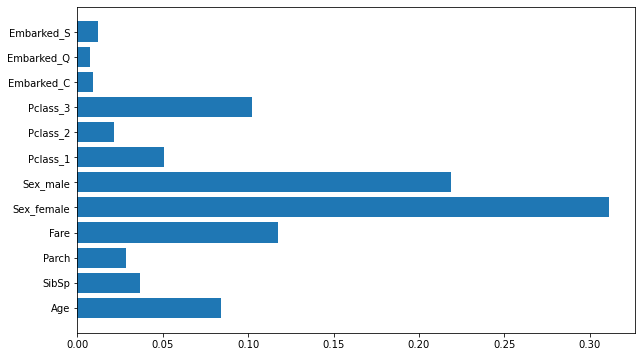

In [75]:
import matplotlib.pyplot as plt

labels = x_train.columns
importances=model.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(range(len(importances)),importances)
plt.yticks(range(len(labels)),labels)
plt.show()


In [76]:
y_test=model.predict(x_test)
y_test=(y_test>0.5).astype(int)


survived_test=pd.Series(y_test,name='Survived')
subm_data = pd.concat([test_id,survived_test],axis=1)

subm_data.to_csv('submission_titanic_rf.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### サポートベクタマシンで調査

In [77]:
from sklearn.svm import SVC

model=SVC()
model.fit(x_train,y_train)

SVC()

In [78]:
y_test=model.predict(x_test)
y_test=(y_test>0.5).astype(int)


survived_test=pd.Series(y_test,name='Survived')
subm_data = pd.concat([test_id,survived_test],axis=1)

subm_data.to_csv('submission_titanic_svc.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### kaggle提出  
スコア:0.66507

#### 特徴量エンジニアリング

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

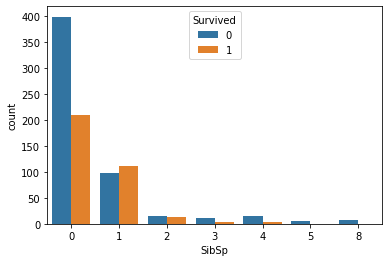

In [81]:
sns.countplot(x='SibSp',hue='Survived',data=train_data)
#plt.legend()
plt.show()

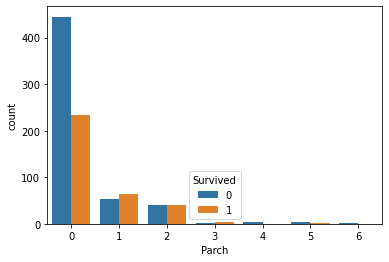

In [82]:
sns.countplot(x='Parch',hue='Survived',data=train_data)

plt.show()

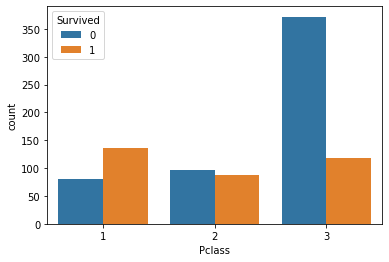

In [83]:
sns.countplot(x='Pclass',hue='Survived',data=train_data)
plt.show()

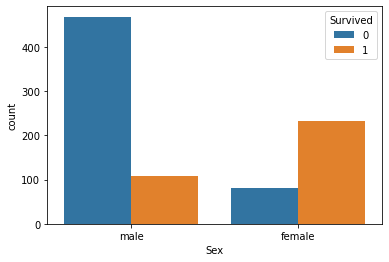

In [84]:
sns.countplot(x='Sex',hue='Survived',data=train_data)
plt.show()

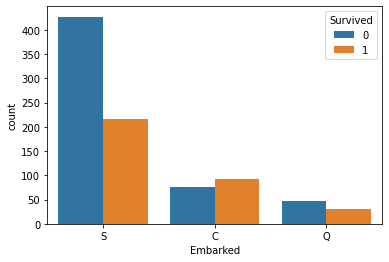

In [85]:
sns.countplot(x='Embarked',hue='Survived',data=train_data)
plt.show()

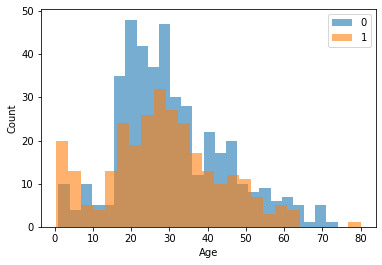

In [86]:
bins = 25
alpha=0.6

plt.hist(train_data.loc[train_data['Survived']==0,'Age'].dropna(),bins=bins,alpha=alpha,label='0')
plt.hist(train_data.loc[train_data['Survived']==1,'Age'].dropna(),bins=bins,alpha=alpha,label='1')

plt.xlabel('Age')
plt.ylabel('Count')

plt.legend()
plt.show()


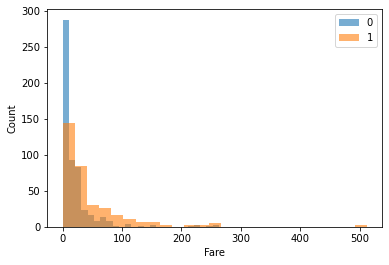

In [87]:


plt.hist(train_data.loc[train_data['Survived']==0,'Fare'].dropna(),bins=25,alpha=0.6,label='0')
plt.hist(train_data.loc[train_data['Survived']==1,'Fare'].dropna(),bins=25,alpha=0.6,label='1')

plt.xlabel('Fare')
plt.ylabel('Count')

plt.legend()
plt.show()

In [88]:
data = pd.concat([train_data,test_data],sort=False)

data['Sex'].replace(['male','female'],[0,1],inplace=True)

data['Embarked'].fillna(('S'),inplace=True)
data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2})

data['Fare'].fillna(data['Fare'].mean(),inplace=True)
data['Age'].fillna(data['Age'].mean(),inplace=True)

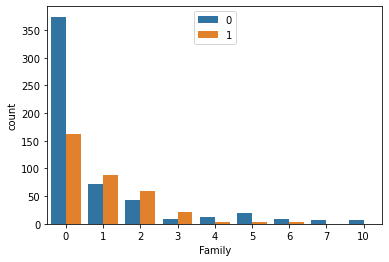

In [89]:
data['Family']=data['Parch'] + data['SibSp']

train_data['Family']=data['Family'][:len(train_data)]
test_data['Family'] = data['Family'][len(train_data):]

sns.countplot(x='Family',data=train_data,hue='Survived')
plt.legend()
plt.show()

In [90]:
data.drop(['Name','PassengerId','SibSp','Parch','Ticket','Cabin'],
           axis=1,inplace=True)

train_data = data[:len(train_data)]
test_data=data[len(train_data):]

t = train_data['Survived']
x_train=train_data.drop('Survived',axis=1)
x_test=test_data.drop('Survived',axis=1)

x_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,0
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,0


## ハイパーパラメータの調節

In [91]:
#pip install optuna
#pip install lightgbm

In [92]:
#study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
#study.optimize(objective,n_trials=30)

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

import lightgbm as lgb
import optuna

train_data = pd.read_csv("train.csv")  # 訓練データ
test_data = pd.read_csv("test.csv") # テストデータ

test_id = test_data["PassengerId"]  # 結果の提出時に使用

data = pd.concat([train_data, test_data], sort=False)  # テストデータ、訓練データを結合

# カテゴリデータの変換
data["Sex"].replace(["male", "female"], [0, 1], inplace=True)
data["Embarked"].fillna(("S"), inplace=True)
data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

# 欠損値を埋める
data["Fare"].fillna(data["Fare"].mean(), inplace=True)
data["Age"].fillna(data["Age"].mean(), inplace=True)

# 新しい特徴量の作成
data["Family"] = data["Parch"] + data["SibSp"]

# 不要な特徴量の削除
data.drop(["Name", "PassengerId", "SibSp", "Parch", "Ticket", "Cabin"],
          axis=1, inplace=True)

# 入力と正解の作成
train_data = data[:len(train_data)]
test_data = data[len(train_data):]
t = train_data["Survived"]  # 正解
x_train = train_data.drop("Survived", axis=1)  # 訓練時の入力
x_test = test_data.drop("Survived", axis=1)  # テスト時の入力

x_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,0
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,0


In [94]:
x_train, x_valid, t_train, t_valid = train_test_split(x_train, t, test_size=0.3, stratify=t)

In [95]:
categorical_features = ["Embarked", "Pclass", "Sex"]

def objective(trial):
    # ハイパーパラメータの探索範囲
    params = {
        "objective": "binary",  # 二値分類
        "max_bin": trial.suggest_int("max_bin", 200, 500),  # 特徴量の最大分割数
        "learning_rate": 0.05,  # 学習率
        "num_leaves": trial.suggest_int("num_leaves", 16, 128)  # 分岐の末端の最大数
    }

    # データセットの作成
    lgb_train = lgb.Dataset(x_train, t_train, categorical_feature=categorical_features)
    lgb_val = lgb.Dataset(x_valid, t_valid, reference=lgb_train, categorical_feature=categorical_features)

    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                      verbose_eval=20,  # 学習過程の表示間隔
                      num_boost_round=500,  # 学習回数の最大値
                      early_stopping_rounds=10)  # 連続して10回性能が向上しなければ終了

    y_valid = model.predict(x_valid, num_iteration=model.best_iteration)  # 訓練済みのモデルを使用
    score = log_loss(t_valid, y_valid)  # 二値の交差エントロピー誤差
    return score

In [96]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=30)

[I 2022-09-26 09:03:31,990] A new study created in memory with name: no-name-a9203efa-7f89-4352-bc20-8a1e1c2ee799
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightG

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2022-09-26 09:03:32,305] Trial 1 finished with value: 0.43969224754549885 and parameters: {'max_bin': 272, 'num_leaves': 67}. Best is trial 0 with value: 0.43969224754549885.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument

[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2022-09-26 09:03:32,446] Trial 2 finished with value: 0.43969224754549885 and parameters: {'max_bin': 223, 'num_leaves': 65}. Best is trial 0 with value: 0.43969224754549885.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's binary_logloss: 0.349971	valid_1's binary_logloss: 0.446439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2022-09-26 09:03:32,591] Trial 3 finished with value: 0.43969224754549885 and parameters: {'max_bin': 324, 'num_leaves': 47}. Best is trial 0 with value: 0.43969224754549885.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	training's binary_logloss: 0.302595	valid_1's binary_logloss: 0.440325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.308256	valid_1's binary_logloss: 0.439692
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhe

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-09-26 09:03:33,016] Trial 6 finished with value: 0.43969224754549885 and parameters: {'max_bin': 303, 'num_leaves': 43}. Best is trial 0 with value: 0.43969224754549885.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's binary_lo

[I 2022-09-26 09:03:33,170] Trial 7 finished with value: 0.43746067858979926 and parameters: {'max_bin': 208, 'num_leaves': 28}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	training's binary_logloss: 0.301104	valid_1's binary_logloss: 0.439962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-09-26 09:03:33,566] Trial 10 finished with value: 0.43969224754549885 and parameters: {'max_bin': 247, 'num_leaves': 28}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's binary_logloss: 0.349971	valid_1's binary_logloss: 0.446439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-09-26 09:03:33,979] Trial 13 finished with value: 0.43969224754549885 and parameters: {'max_bin': 474, 'num_leaves': 45}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-09-26 09:03:34,121] Trial 14 finished with value: 0.43969224754549885 and parameters: {'max_bin': 261, 'num_leaves': 85}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[60]	training's binary_logloss: 0.302595	valid_1's binary_logloss: 0.440325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.308256	valid_1's binary_logloss: 0.439692
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's binary_logloss: 0.424853	valid_1's binary_logloss: 0.484275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	training's binary_logloss: 0.424853	valid_1's binary_logloss: 0.484275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2022-09-26 09:03:34,717] Trial 18 finished with value: 0.43969224754549885 and parameters: {'max_bin': 390, 'num_leaves': 65}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2022-09-26 09:03:34,855] Trial 19 finished with value: 0.43969224754549885 and parameters: {'max_bin': 416, 'num_leaves': 125}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argume

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-09-26 09:03:35,107] Trial 21 finished with value: 0.43969224754549885 and parameters: {'max_bin': 228, 'num_leaves': 32}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's binary_logloss: 0.349971	valid_1's binary_logloss: 0.446439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

[I 2022-09-26 09:03:35,247] Trial 22 finished with value: 0.43969224754549885 and parameters: {'max_bin': 424, 'num_leaves': 126}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argume

[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2022-09-26 09:03:35,518] Trial 24 finished with value: 0.43969224754549885 and parameters: {'max_bin': 423, 'num_leaves': 106}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argume

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	training's binary_logloss: 0.349971	valid_1's binary_logloss: 0.446439
[LightGBM] [Warning] No 

[I 2022-09-26 09:03:35,652] Trial 25 finished with value: 0.43969224754549885 and parameters: {'max_bin': 407, 'num_leaves': 71}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen

[60]	training's binary_logloss: 0.302595	valid_1's binary_logloss: 0.440325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.308256	valid_1's binary_logloss: 0.439692
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[I 2022-09-26 09:03:36,040] Trial 28 finished with value: 0.43969224754549885 and parameters: {'max_bin': 490, 'num_leaves': 27}. Best is trial 7 with value: 0.43746067858979926.
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argumen


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [97]:
print(study.best_params)

{'max_bin': 483, 'num_leaves': 16}


In [98]:
params={
    'objective':'binary',
    'max_bin':study.best_params['max_bin'],
    'learing_rate':0.05,
    'num_leaves':study.best_params['num_leaves']
}

lgb_train=lgb.Dataset(x_train,t_train,categorical_feature=categorical_features)
lgb_val=lgb.Dataset(x_valid,t_valid,reference=lgb_train,categorical_feature=categorical_features)

model=lgb.train(params,lgb_train,valid_sets=[lgb_train,lgb_val],
                  verbose_eval=20,
                  num_boost_round=500,
                  early_stopping_rounds=10)

y_test=model.predict(x_test,num_iteration=model.best_iteration)

[LightGBM] [Warning] Unknown parameter: learing_rate
[LightGBM] [Warning] Unknown parameter: learing_rate
[LightGBM] [Info] Number of positive: 239, number of negative: 384
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 186
[LightGBM] [Info] Number of data points in the train set: 623, number of used features: 6
[LightGBM] [Warning] Unknown parameter: learing_rate
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383628 -> initscore=-0.474179
[LightGBM] [Info] Start training from score -0.474179
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.360033	valid_1's binary_logloss: 0.443122


C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[40]	training's binary_logloss: 0.289424	valid_1's binary_logloss: 0.437718
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.303396	valid_1's binary_logloss: 0.430487


In [99]:
y_test=(y_test>0.5).astype(int)

survived_test=pd.Series(y_test,name='Survived')
subm_data=pd.concat([test_id,survived_test],axis=1)

subm_data.to_csv('submission_titanic_hp.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### kaggle提出  
'submission_titanic_hp.csv' → アルゴリズムはlightGBM

スコア:0.66507 → 0.78468  
1825位/13427位中

## 交差検証 過学習の対処

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [101]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')


In [102]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [103]:
test_id = test_data['PassengerId']

In [104]:
data=pd.concat([train_data,test_data],sort=False)

In [105]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].fillna(('S'),inplace=True)
data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2})

In [106]:
data['Fare'].fillna(data['Fare'].mean(),inplace=True)
data['Age'].fillna(data['Age'].mean(),inplace=True)

In [107]:
data['Family']=data['Parch']+data['SibSp']

In [108]:
data.drop(['Name','PassengerId','SibSp','Parch','Ticket','Cabin'],
           axis=1,inplace=True)

In [109]:
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Family
0,0.0,3,0,22.0,7.2500,0,1
1,1.0,1,1,38.0,71.2833,1,1
2,1.0,3,1,26.0,7.9250,0,0
3,1.0,1,1,35.0,53.1000,0,1
4,0.0,3,0,35.0,8.0500,0,0


In [110]:
train_data=data[:len(train_data)]
test_data=data[len(train_data):]
t=train_data['Survived']
x_train=train_data.drop('Survived',axis=1)
x_test=test_data.drop('Survived',axis=1)

In [111]:
x_train.head()

,Pclass,Sex,Age,Fare,Embarked,Family
0,3,0,22.0,7.2500,0,1
1,1,1,38.0,71.2833,1,1
2,3,1,26.0,7.9250,0,0
3,1,1,35.0,53.1000,0,1
4,3,0,35.0,8.0500,0,0


In [112]:
y_valid=np.zeros((len(x_train),))
y_test=[]

skf = StratifiedKFold(n_splits=5,shuffle=True)

In [113]:
y_valids = np.zeros((len(x_train),)) # 予測結果: 検証用データ
y_tests = []  # 予測結果: テスト用データ

skf = StratifiedKFold(n_splits=5, shuffle=True)

# ハイパーパラメータの設定
params = {
    "objective": "binary",  # 二値分類
    "max_bin": 300,  # 特徴量の最大分割数
    "learning_rate": 0.05,  # 学習率
    "num_leaves": 32  # 分岐の末端の最大数
}

categorical_features = ["Embarked", "Pclass", "Sex"]

for _, (ids_train, ids_valid) in enumerate(skf.split(x_train, t)):
    x_tr = x_train.loc[ids_train, :]
    x_val = x_train.loc[ids_valid, :]
    t_tr = t[ids_train]
    t_val = t[ids_valid]

    # データセットの作成
    lgb_train = lgb.Dataset(x_tr, t_tr, categorical_feature=categorical_features)
    lgb_val = lgb.Dataset(x_val, t_val, reference=lgb_train, categorical_feature=categorical_features)
    
    # モデルの訓練
    model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_val],
                      verbose_eval=20,  # 学習過程の表示間隔
                      num_boost_round=500,  # 学習回数の最大値
                      early_stopping_rounds=10)  # 連続して10回性能が向上しなければ終了

    # 結果を保持
    y_valids[ids_valid] = model.predict(x_val, num_iteration=model.best_iteration)
    y_test = model.predict(x_test, num_iteration=model.best_iteration)
    y_tests.append(y_test)

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Tsubasa\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [114]:
y_valids_bin=(y_valids>0.5).astype(int)
accuracy_score(t,y_valids_bin)

0.8338945005611672

In [115]:
y_test_subm=sum(y_tests)/len(y_tests)
y_test_subm=(y_test>0.5).astype(int)

survived_test = pd.Series(y_test_subm,name='Survived')
subm_data=pd.concat([test_id,survived_test],axis=1)

subm_data.to_csv('submision_titanic_cv.csv',index=False)

subm_data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### 結果  
スコア:0.76555

In [116]:
import pandas as pd

subm_rf = pd.read_csv('submission_titanic_rf.csv')
subm_svc = pd.read_csv('submission_titanic_svc.csv')
subm_lgbm = pd.read_csv('submision_titanic_cv.csv')

ensemble_df = pd.DataFrame({'subm_rf':subm_rf['Survived'].values,
                           'subm_svc':subm_svc['Survived'].values,
                           'subm_lgbm':subm_lgbm['Survived'].values,})

ensemble_df


,subm_rf,subm_svc,subm_lgbm
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
413,0,0,0
414,1,1,1
415,0,0,0
416,0,0,0


In [117]:
ensemble_df.corr()

,subm_rf,subm_svc,subm_lgbm
subm_rf,1.000000,0.234398,0.856363
subm_svc,0.234398,1.000000,0.229827
subm_lgbm,0.856363,0.229827,1.000000


In [126]:
subm_data = subm_rf.copy()

subm_data['Survived']=subm_rf['Survived'] + subm_svc['Survived'] + subm_lgbm['Survived']
subm_data['Survived'] = (subm_data['Survived']>=2).astype(int)

subm_data.to_csv('submission_titanic_ensemble.csv',index=False)

subm_data.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


スコア:0.77990  
1791位/13376位